In [1]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import pandas as pd
import json
import numpy as np
from collections import Counter
import ast

def Hindex(citations):
    n = len(citations)
    citations.sort(reverse=True)  # 将引用量列表按降序排序

    h_index = 0
    for i in range(n):
        if citations[i] >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index

def Gindex(indexList):
#     indexList = [int(num) for num in indexList]
    #构建引用次数与文章篇数的映射
    HCounter = Counter(indexList)
    #逆序字典，让引用次数高的引用次数排在前面
    ReversedCounter = sorted(HCounter.items(), reverse = True)
    #分别生成 引用次数列表CounterKeys 和 该引用次数的文章列表CounterValues
    CounterKeys = [i[0] for i in ReversedCounter ]
    CounterValues = [i[1] for i in ReversedCounter]
    #CounterKeys，CounterValues根据索引值一一对应，遍历索引值
    for index in range(0,len(CounterValues)):
        #sum(CounterValues[0:index+1])为大于等于某个索引值——CounterKeys[index]的所有的文章总和
        if sum([CounterKeys[i]*CounterValues[i] for i in range(index)]) <= math.pow(sum(CounterValues[0:index+1]),2):
            break
    return CounterKeys[index]
# 判断字符重合
def compare_letters(str1, str2):
    str1 = str(str1)
    str2 = str(str2)
    # 去除字符串中的非字母字符，并转换为小写字母
    letters1 = ''.join(filter(str.isalpha, str1.lower()))
    letters2 = ''.join(filter(str.isalpha, str2.lower()))

    # 判断两个字符串中的字母是否相同
    return sorted(letters1) == sorted(letters2)
# 判断字符重合度
def check_letter_overlap(str1, str2):
    str1 = str(str1)
    str2 = str(str2)
    # 将字符串中的非英文字母字符去除，转换为小写
    str1 = ''.join(filter(str.isalpha, str1.lower()))
    str2 = ''.join(filter(str.isalpha, str2.lower()))
    
    # 统计两个字符串中的英文字母个数
    count1 = len(str1)
    count2 = len(str2)
    
    # 统计两个字符串中重叠的英文字母个数
    overlap_count = sum([1 for char in str1 if char in str2])
    
    # 计算重叠度
    overlap_percentage = (overlap_count / max(count1, count2)) * 100
    
    # 判断重叠度是否超过90%
    return overlap_percentage
# 返回索引
def sort_with_indices(numbers):
    # Enumerate the numbers and store them as tuples with their indices
    enumerated_numbers = list(enumerate(numbers))
    
    # Sort the enumerated numbers in descending order based on the values
    sorted_numbers = sorted(enumerated_numbers, key=lambda x: x[1], reverse=True)
    
    # Extract the indices from the sorted list and return them
    indices = [x[0] for x in sorted_numbers]
    return indices

In [6]:
df = pd.read_excel('Total Articles of 287 ACM Fellows.xlsx')
df.head()

,Fellow,Title,Year,Authorlist,Cited,Contribution,Position,Persons,Cited_weight
0,"Markl, Volker",query processing on heterogeneous cpugpu systems,2023,"[Viktor Rosenfeld, Sebastian Breß, Volker Markl]",0.0,0.181818,3,3,0.000000
1,"Markl, Volker",the seattle report on database research,2022,"[Daniel Abadi, Anastasia Ailamaki, David G. An...",24.0,0.012229,20,33,0.293485
2,"Balazinska, Magdalena",the seattle report on database research,2022,"[Daniel Abadi, Anastasia Ailamaki, David G. An...",24.0,0.048914,5,33,1.173939
3,"Markl, Volker",handling iterations in distributed dataflow sy...,2022,"[Gábor E. Gévay, Juan Soto 0001, Volker Markl]",0.0,0.181818,3,3,0.000000
4,"Markl, Volker",making learned query optimization practical a ...,2022,[Volker Markl],0.0,1.000000,1,1,0.000000


In [7]:
# 从JSON文件中读取数据
with open('学者生产力曲线.json', 'r') as f:
    data = json.load(f)

In [8]:
# 保存为生产力-h指数-引用量数据
dict1 = {}
for item in df.iloc[:,0].unique():
    if not str(item) == "nan":
        df1 = df[df['Fellow']==item]
        df1 = df1[df1['Cited']>0]
        productlist = data[item.replace(', ',',\u00a0')]['productlist']
        total_article = sum(productlist)
        year_list = data[item.replace(', ',',\u00a0')]['yearlist']
        cited_list = df1["Cited_weight"].tolist()
        total_cite = sum(cited_list)
        hlist = []
        citedsum_list = []
        productsum_list = []
        for year1 in range(min(year_list),max(year_list)+1):
            yearlist1 = df1[df1["Year"]<=year1]["Cited_weight"].tolist()
            productsum_list.append(sum([productlist[i1] for i1 in range(year1-min(year_list)+1)]))
            if len(year_list)==0:
                hlist.append(0)
                citedsum_list.append(0)
            else:
                hlist.append(Hindex(yearlist1))
                citedsum_list.append(sum(yearlist1))

        dict1[item.strip()] = {
            "total_article":total_article,
            "total_cite":total_cite,
            "per_cite":total_cite/total_article,
            "h_index":Hindex(cited_list),
            "career":max(year_list)-min(year_list)+1,
            "year_list":[i1 for i1 in range(min(year_list),max(year_list)+1,1)],
            "hlist":hlist,
            "citedsum_list":citedsum_list,
            "productsum_list":productsum_list,
        }

In [9]:
data = json.dumps(dict1)
# 保存为JSON文件
with open('学者影响力-生产力曲线.json', 'w') as f:
    f.write(data)
    f.close()

In [10]:
# 从JSON文件中读取数据
with open('学者生产力曲线.json', 'r') as f:
    data = json.load(f)
dict1 = {}
for item in df.iloc[:,0].unique():
#     try:
    if not str(item) == "nan":
        df1 = df[df['Fellow']==item]
        df1 = df1[df1['Cited']>0]
        total_article = sum(data[item.replace(', ',',\u00a0')]['productlist'])
        year_list = df1["Year"].tolist()
        if len(year_list)>0:
            year_list = data[item.replace(', ',',\u00a0')]['yearlist']
            cited_list = df1["Cited_weight"].tolist()
            total_cite = sum(cited_list)
            hlist = []
            citedsum_list = []
            for year1 in range(min(year_list),max(year_list)+1):
                yearlist1 = df1[df1["Year"]<=year1]["Cited_weight"].tolist()
                if len(year_list)==0:
                    hlist.append(0)
                    citedsum_list.append(0)
                else:
                    hlist.append(Hindex(yearlist1))
                    citedsum_list.append(sum(yearlist1))

            dict1[item] = {
                "total_article":total_article,
                "total_cite":total_cite,
                "per_cite":total_cite/total_article,
                "h_index":Hindex(cited_list),
                "career":max(year_list)-min(year_list)+1,
                "year_list":[i1 for i1 in range(min(year_list),max(year_list)+1,1)],
                "hlist":hlist,
                "citedsum_list":citedsum_list
            }

In [11]:
year1 = [year-min(dict1[key1]["year_list"]) for key1 in dict1.keys() for year in dict1[key1]["year_list"]]
list1 = []
for key1 in dict1.keys():
    list3 = []
    list3.append(key1)
    yearcounter = {}
    for year11 in range(len(dict1[key1]["year_list"])):
        yearcounter[dict1[key1]["year_list"][year11]] = dict1[key1]["hlist"][year11]
    list2 = [item for item in yearcounter.keys()]
    for item1 in range(min(list2),max(list2)+1,1):
        if item1 in list2:
            list3.append(yearcounter[item1])
        else:
            list3.append(0)
    for item1 in range(max(list2)-min(list2)+1,max(year1)+1,1):
        list3.append('')
    list1.append(list3)
# 标准化
for i in range(len(list1)):
    list11 = [i1 for i1 in list1[i] if not i1 == ''][1:]
    max1,min1 = max(list11),min(list11)
    if max1 == min1:
        for j in range(1,len(list1[i])):
            if not list1[i][j] == '':
                list1[i][j] = 1
    else:
        for j in range(1,len(list1[i])):
            if not list1[i][j] == '':
                list1[i][j] = (list1[i][j]-min1)/(max1-min1)
list3 = []
for item in list1:
    list33 = [item1 for item1 in item if not item1 == '']
    list3.append(list33)
#     if len(list33)>21:
#         list3.append(list33)

In [12]:
maxage = max([len(i)-1 for i in list3])
# 构建DataFrame
columns1 = ['Name'] + [i+1 for i in range(maxage)]
df = pd.DataFrame(list3, columns=columns1)
df.head()

,Name,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,"Markl, Volker",0.0,0.090909,0.181818,0.181818,0.272727,0.363636,0.363636,0.363636,0.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Balazinska, Magdalena",0.0,0.052632,0.052632,0.105263,0.210526,0.315789,0.368421,0.368421,0.526316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Madden, Samuel",0.0,0.074074,0.148148,0.296296,0.370370,0.481481,0.555556,0.666667,0.814815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Tao, Yufei",0.0,0.051282,0.102564,0.282051,0.435897,0.564103,0.666667,0.794872,0.871795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Mataric, Maja",0.0,0.000000,0.036364,0.036364,0.036364,0.090909,0.109091,0.200000,0.290909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# 利用DTW计算曲线相似性
# curve1 = [1, 2, 3, 4, 5]
# curve2 = [2, 4, 6, 8]
def similar1(curve1,curve2):
    curve1 = [(i-min(curve1))/(max(curve1)-min(curve1)) for i in curve1]
    curve2 = [(i-min(curve2))/(max(curve2)-min(curve2)) for i in curve2]

    # 定义距离函数，这里使用欧氏距离
    distance = lambda x, y: euclidean(x, y)

    # 使用fastdtw计算DTW距离
    distance, path = fastdtw(curve1, curve2, dist=distance)

    # 输出DTW距离和对齐路径
#     print("DTW Distance:", distance)
    return distance

In [16]:
list4 = []
# 创建相似性矩阵
similarity_matrix = np.zeros((len(list3), len(list3)))
for i in range(len(list3)):
    for j in range(i+1,len(list3)):
        similar = similar1(list3[i][1:],list3[j][1:])
        list4.append([list3[i],list3[j],similar])
        similarity_matrix[i][j] = similar
        similarity_matrix[j][i] = similar  # 如果相似性是对称的，同时填充对角线上的值

In [18]:
# 去除第一行和第二列
new_matrix = np.delete(similarity_matrix, 286, axis=0)  # 删除第一行
new_matrix = np.delete(new_matrix, 286, axis=1)  # 删除第二列

In [19]:
# 将矩阵数据转换为DataFrame对象
df11 = pd.DataFrame(new_matrix,columns=[item[0] for item in list33])
df11.head()
# 将DataFrame保存为Excel文件
df11.to_excel(f'职业年龄大于等于20岁的{len(list33)}个学者h指数距离矩阵.xlsx', index=False)

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distance_matrix = similarity_matrix
# 初始化聚类个数的范围
min_k = 2
max_k = 50
k_values = range(min_k, max_k+1)

# 存储每个聚类个数对应的评估指标值
inertia_values = []
silhouette_scores = []

# 遍历不同的聚类个数
for k in k_values:
    # 使用K-means聚类
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(new_matrix)
    
    # 计算簇内平方和（inertia）
    inertia_values.append(kmeans.inertia_)
    
    # 计算轮廓系数
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(new_matrix, labels, metric='euclidean'))

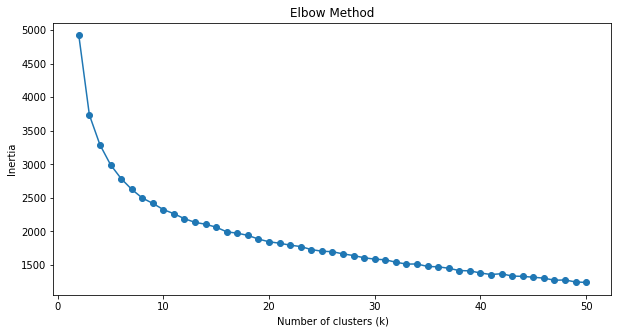

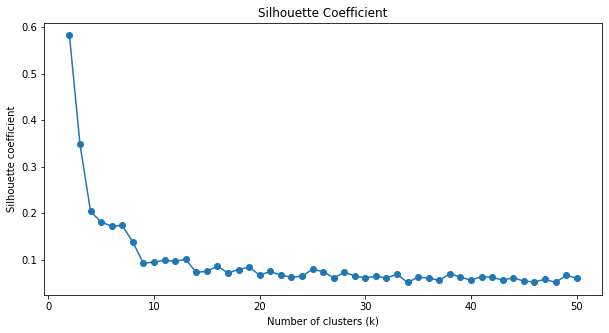

In [21]:
# 绘制肘部法则曲线
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# 绘制轮廓系数曲线
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Coefficient')
plt.show()

In [22]:
# 构建DataFrame
data = {'聚类个数': [i for i in k_values], '簇内平方和': inertia_values, '轮廓系数': silhouette_scores}
df = pd.DataFrame(data)
df.to_excel('学术影响力成长轨迹聚类个数判断数据.xlsx',index=False)

In [23]:
# 聚类个数为4时的结果
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_matrix)
list5 = []
for i in range(len(list33)):
    name1 = list33[i][0]
    x = 1
    list55 = []
    for j in list33[i][1:]:
        list5.append([name1,x,j,kmeans.labels_[i],'normal'])
        x = x + 1
for i in kmeans.labels_:
    list55 = [list33[j] for j,item in enumerate(kmeans.labels_) if item == i]
    maxage = max([len(item[1:]) for item in list55])
    for i1 in range(1,maxage+1):
        test = [item[i1] for item in list55 if len(item)>i1]
        mean1 = sum(test)/len(test)
        list5.append(['Mean',i1,mean1,i,'mean'])
df = pd.DataFrame(list5,columns=['姓名','职业年龄','标准化发文量','聚类类别','类型'])
df.to_excel('聚类为4时学术影响力轨迹聚类结果绘图数据-不结合发文量.xlsx',index=False)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(new_matrix)
# kmeans = KMeans(n_clusters=4)
# kmeans.fit(new_matrix)

In [25]:
list1 = []
for i in set(kmeans.labels_):
    x1 = reduced_data[[j for j, item in enumerate(kmeans.labels_) if item == i],0]
    y1 = reduced_data[[j for j, item in enumerate(kmeans.labels_) if item == i],1]
    for i1 in range(len(x1)):
        list1.append([x1[i1],y1[i1],i,'normal'])
    list1.append([sum(x1)/len(x1),sum(y1)/len(y1),i,'mean'])
df = pd.DataFrame(list1,columns=['x','y','聚类类别','类型'])
df.to_excel('h指数主成分分析聚类结果.xlsx',index=False)

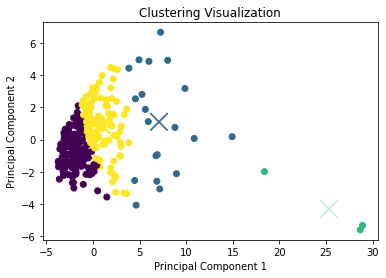

In [64]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_matrix)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(new_matrix)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
xlist,ylist = [],[]
for i in kmeans.labels_:
    x1 = reduced_data[[j for j, item in enumerate(kmeans.labels_) if item == i],0]
    y1 = reduced_data[[j for j, item in enumerate(kmeans.labels_) if item == i],1]
    xlist.append(sum(x1)/len(x1))
    ylist.append(sum(y1)/len(y1))
    
plt.scatter(xlist, ylist, c=kmeans.labels_, marker='x', label='Cluster Centers',s=300,alpha=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Visualization')
plt.show()